In [1]:
from torch.utils.data import Dataset
import torch
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import os
import math
import time

import numpy as np
import matplotlib.pyplot as plt
import random

import librosa
import librosa.display
from scipy import signal
from tqdm import tqdm
import multiprocessing

/home/yhbedoya/VirtualEnvs/SHMmae_venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def _readCSV():
    print(f'reading CSV files')
    start = datetime.strptime(start_time, '%d/%m/%Y %H:%M')
    end = datetime.strptime(end_time, '%d/%m/%Y %H:%M')

    ldf = list()
    for p in tqdm(glob.glob(path + "*.csv")):
        name = os.path.split(p)[-1]
        nstr = datetime.strptime(name, 'traffic_%Y%m%dH%H%M%S.csv')
        if start <= nstr < end:
            df_tmp = pd.read_csv(p)
            c_drop = set(df_tmp.columns) - set(["sens_pos", "z", "ts"])
            if len(c_drop) > 0:
                df_tmp.drop(columns=list(c_drop), inplace=True)
            ldf.append(df_tmp)
    df = pd.concat(ldf).sort_values(by=['sens_pos', 'ts'])
    df.reset_index(inplace=True, drop=True)

    #df = df[df['sens_pos'].isin(self.sensors)]
    df['ts'] = pd.to_datetime(df['ts'], unit='ms')

    return df

In [78]:
def _partitioner():
    sensors = data['sens_pos'].unique().tolist()
    print(f'start partitioner')
    partitions = {}
    cumulatedWindows = 0
    limits = dict()
    for sensor in sensors:
        sensorData = data[data['sens_pos']==sensor]
        totalFrames = sensorData.shape[0]
        totalWindows = math.ceil((totalFrames-windowLength)/windowStep)
        start = cumulatedWindows
        cumulatedWindows += totalWindows
        end = cumulatedWindows
        indexStart = sensorData.index[0]
        partitions[sensor]= (start, end, indexStart)

    timeData = torch.tensor(data["z"].values, dtype=torch.float64)
    cummulator = -1

    mins = list()
    maxs = list()
    print(f'Defining windows limits')
    noiseFreeSpaces = 1
    positives = []
    for index in tqdm(range(0, cumulatedWindows)):
        for k,v in partitions.items():
            if index in range(v[0], v[1]):
            #print(f'index: {index}')
                start = v[2]+(index-v[0])*windowStep
                std = torch.std(timeData[start: start+windowLength])
                
                if std > 0.001:
                    positives.append(index)
                    cummulator += 1
                    limits[cummulator] = (start, start+windowLength)
                    slice = timeData[start:start+windowLength]
                    frequencies, times, spectrogram = _transformation(torch.tensor(slice, dtype=torch.float64))
                    mins.append(torch.min(torch.tensor(spectrogram, dtype=torch.float64)))
                    maxs.append(torch.max(torch.tensor(spectrogram, dtype=torch.float64)))
                    noiseFreeSpaces += 1
                    
                elif True:
                    cummulator += 1
                    limits[cummulator] = (start, start+windowLength)
                    slice = timeData[start:start+windowLength]
                    frequencies, times, spectrogram = _transformation(torch.tensor(slice, dtype=torch.float64))
                    mins.append(torch.min(torch.tensor(spectrogram, dtype=torch.float64)))
                    maxs.append(torch.max(torch.tensor(spectrogram, dtype=torch.float64)))
                    noiseFreeSpaces -= 1
                break
    print(f'Total windows in dataset: {cummulator}')
    min = torch.min(torch.tensor(mins, dtype=torch.float64))
    max = torch.max(torch.tensor(mins, dtype=torch.float64))
    print(f'General min: {min}')
    print(f'General max: {max}')
    return timeData, limits, cummulator, min, max, positives

In [107]:
def _transformation(slice):
    
    sliceN = slice-torch.mean(slice)
    frequencies, times, spectrogram = signal.spectrogram(sliceN,sampleRate,nfft=frameLength,noverlap=(frameLength - stepLength), nperseg=frameLength,mode='psd')

    return frequencies, times, spectrogram

def _normalizer(spectrogram):
    spectrogramNorm = (spectrogram - min) / (max - min)

    return spectrogramNorm

In [9]:
def plotSpect(frequencies, times, spectrogram, index, std):
    plt.figure(figsize=(10, 5))
    plt.title(f'spectrogram from PSD: {std}')
    plt.pcolormesh(times, frequencies, 10*np.log10(np.squeeze(spectrogram)), vmin=-150, vmax=-50)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(format="%+2.f", label='dB')
    plt.savefig(f'../spect/{index}.png')

In [10]:
start_time, end_time = "05/12/2021 23:30", "06/12/2021 00:00"
path = '/home/yhbedoya/Repositories/SHM-MAE/traffic/'
sampleRate = 100
frameLength = 198
stepLength = 10
windowLength= 990
windowStep = 100

In [79]:
data = _readCSV()

reading CSV files


100%|██████████| 30/30 [00:12<00:00,  2.39it/s]


In [80]:
data, limits, totalWindows, min, max, positives = _partitioner()

start partitioner
Defining windows limits


100%|██████████| 187305/187305 [01:23<00:00, 2240.33it/s]


Total windows in dataset: 187304
General min: 8.447780910818805e-23
General max: 1.6597717571614512e-11


In [16]:
def __getitem__(index):
    start, end = limits[index]
    slice = data[start:end]
    frequencies, times, spectrogram = _transformation(slice)
    return frequencies, times, spectrogram, slice

In [35]:
def printPSD(window):

    f, Pxx_den = signal.welch(window, 100, nperseg=100)

    plt.semilogy(f, Pxx_den)
    plt.ylim([0.5e-10, 0.5e-5])
    plt.title("PSD from signal")
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')

In [39]:
def plotSpect(frequencies, times, spectrogram, index):
    #plt.figure(figsize=(10, 5))
    plt.title(f'spectrogram from PSD')
    plt.pcolormesh(times, frequencies, 10*np.log10(np.squeeze(spectrogram)), vmin=-150, vmax=-50)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(format="%+2.f", label='dB')
    #plt.savefig(f'../spect/{index}.png')

In [45]:
def printPlots(frequencies, times, spectrogram, slice, index):

    plt.rcParams['figure.figsize'] = [16, 7]

    plt.subplot(1, 2, 1)
    printPSD(slice)

    plt.subplot(1, 2, 2)
    plotSpect(frequencies, times, spectrogram, index)
    plt.savefig(f'../spect/comparison.png')

In [218]:
ampPos = []
ampNoise = []
falsePositives = []
falseNegatives = []
for index in tqdm(range(len(limits))):
    #index = positives[i]
    frequencies, times, spectrogram, slice = __getitem__(index)
    sliceN = slice-torch.mean(slice)
    y = butter_bandpass_filter(sliceN, lowcut, highcut, fs)
    amp = np.max(y)-np.min(y)
    if index in positives:
        ampPos.append(amp)
        if amp < 0.007:
            falsePositives.append(index)
    else:
        ampNoise.append(amp)
        if amp > 0.007:
            falseNegatives.append(index)

    #printPlots(frequencies, times, spectrogram, sliceN, index)

100%|██████████| 187305/187305 [01:41<00:00, 1839.38it/s]


In [203]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=10):
    return butter(order, [1, 49], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=1):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

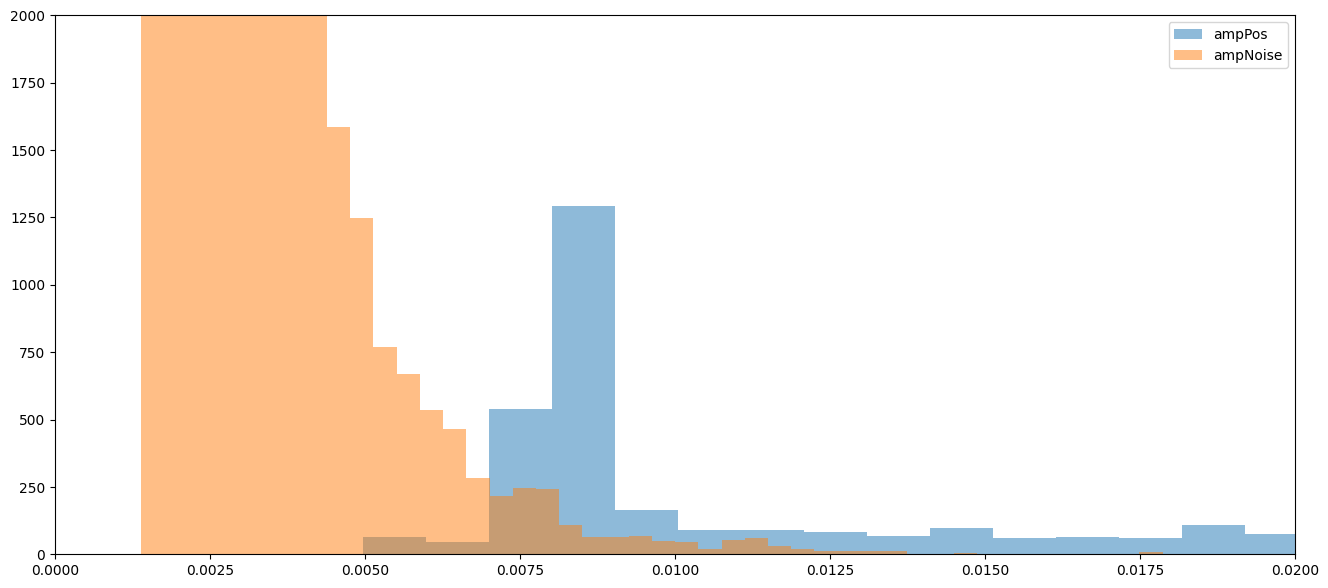

In [208]:
plt.hist(ampPos, bins=50, alpha=0.5, label='ampPos')
plt.hist(ampNoise, bins=50, alpha=0.5, label='ampNoise')
plt.ylim([0,2000])
plt.xlim([0,0.02])
plt.legend(loc='upper right')
plt.show()

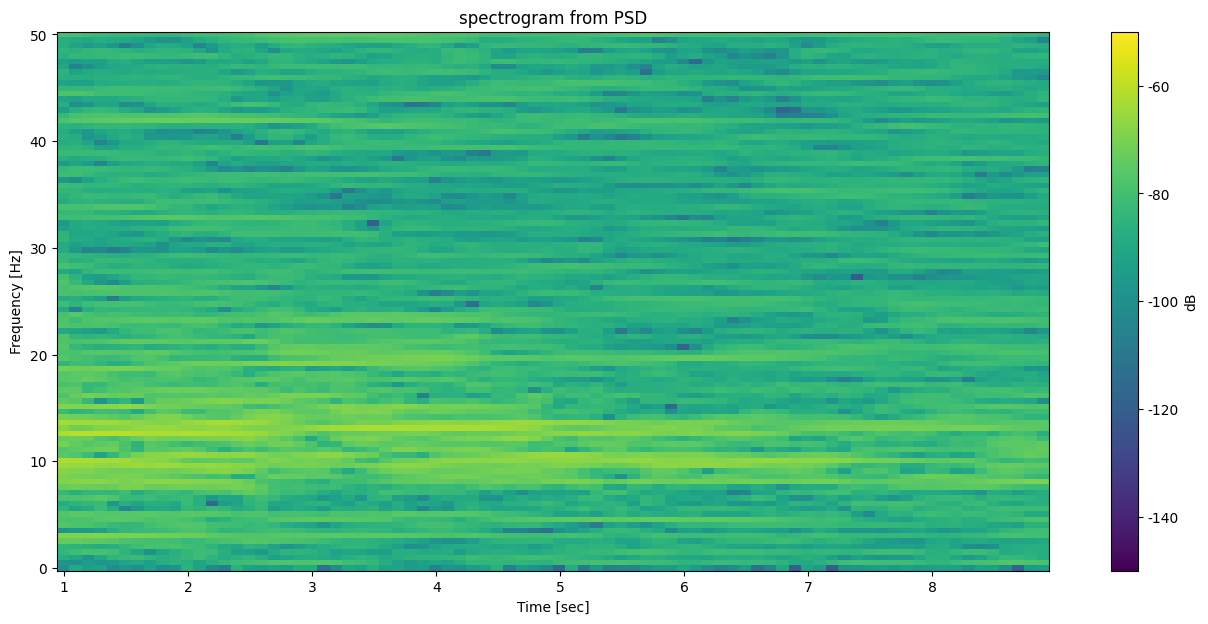

In [233]:
frequencies, times, spectrogram, slice = __getitem__(falseNegatives[95])
plotSpect(frequencies, times, spectrogram, 0)

In [219]:
len(falseNegatives)

1349